In [12]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from tslearn.preprocessing import TimeSeriesScalerMinMax
sys.path.append(os.path.join(os.path.dirname('Demand'), '..', 'src'))
from Demand import Demand

In [13]:
path = '../data/demand_lower_48'

In [14]:
nat_dem = Demand()

In [17]:
nat_dem.load_and_clean_data(path)

In [19]:
df = nat_dem.dataframe

In [20]:
df.head()

,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
Time,,,,,,,
2015-07-01 02:00:00,335153,2015,7,2,2,1,182
2015-07-01 03:00:00,333837,2015,7,3,2,1,182
2015-07-01 04:00:00,398386,2015,7,4,2,1,182
2015-07-01 05:00:00,388954,2015,7,5,2,1,182
2015-07-01 06:00:00,392487,2015,7,6,2,1,182


In [6]:
def create_X_matrix(df, seq_len):
    X = []
    for i in range(seq_len, len(df)):
        X.append(df['Megawatthours'].iloc[i-seq_len:i].values)
    return np.array(X)

In [7]:
split_index_1 = 40919

In [22]:
y = df['Megawatthours'].values

In [24]:
scaler = MinMaxScaler()

In [26]:
y_train = y[:split_index_1]
y_test = y[split_index_1:]

In [27]:
y_train.shape

(40919,)

In [28]:
y_test.shape

(9260,)

In [29]:
y_train = scaler.fit_transform(y_train.reshape(-1, 1))

In [35]:
y_train.shape

(40919, 1)

In [32]:
y_test = scaler.transform(y_test.reshape(-1, 1))

In [34]:
y_test

array([[0.34793966],
       [0.31994601],
       [0.30042781],
       ...,
       [0.22443127],
       [0.24232837],
       [0.26591838]])

In [37]:
y_train = y_train.reshape(-1)

In [38]:
y_train.shape

(40919,)

In [39]:
y_test = y_test.reshape(-1)

In [40]:
y_test.shape

(9260,)

In [42]:
y = np.concatenate((y_train, y_test), axis=0)

In [43]:
y.shape

(50179,)

In [47]:
y_reformed_df = pd.DataFrame(y, index=df.index, columns=['Megawatthours'])

In [48]:
y_reformed_df.head()

,Megawatthours
Time,
2015-07-01 02:00:00,0.141926
2015-07-01 03:00:00,0.138975
2015-07-01 04:00:00,0.283706
2015-07-01 05:00:00,0.262557
2015-07-01 06:00:00,0.270479


In [49]:
X_matrix = create_X_matrix(y_reformed_df, 20)

In [55]:
X_matrix

array([[0.14192568, 0.13897496, 0.28370561, ..., 0.70508123, 0.67445078,
        0.63414979],
       [0.13897496, 0.28370561, 0.26255734, ..., 0.67445078, 0.63414979,
        0.60870101],
       [0.28370561, 0.26255734, 0.27047898, ..., 0.63414979, 0.60870101,
        0.55833935],
       ...,
       [0.29284699, 0.285672  , 0.26451253, ..., 0.21147818, 0.20517989,
        0.20888398],
       [0.285672  , 0.26451253, 0.23602111, ..., 0.20517989, 0.20888398,
        0.22443127],
       [0.26451253, 0.23602111, 0.21244456, ..., 0.20888398, 0.22443127,
        0.24232837]])

In [52]:
y = y_reformed_df.iloc[20:].values

In [54]:
y

array([[0.60870101],
       [0.55833935],
       [0.47952887],
       ...,
       [0.22443127],
       [0.24232837],
       [0.26591838]])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, shuffle=False)

In [67]:
X_train = np.reshape(X_train, (X_train.shape[0], 20, 1))
X_train.shape

(37619, 20, 1)

In [68]:
X_test = np.reshape(X_test, (X_test.shape[0], 20, 1))
X_test.shape

(12540, 20, 1)

In [70]:
y_train = y_train.reshape(-1)
y_train.shape

(37619,)

In [71]:
y_test = y_test.reshape(-1)
y_test.shape

(12540,)

## RNN

In [110]:
rnn_model = Sequential()

In [111]:
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 20, 40)            1680      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 20, 40)            3240      
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [112]:
rnn_model.compile(optimizer='adam', loss='MAE')
rnn_model.fit(X_train, y_train, epochs=100, batch_size=1000)

Epoch 1/100
38/38 [==============================] - 1s 23ms/step - loss: 0.3773
Epoch 2/100
38/38 [==============================] - 1s 21ms/step - loss: 0.2154
Epoch 3/100
38/38 [==============================] - 1s 21ms/step - loss: 0.1271
Epoch 4/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0899
Epoch 5/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0699
Epoch 6/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0579
Epoch 7/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0506
Epoch 8/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0449
Epoch 9/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0408
Epoch 10/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0377
Epoch 11/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0351
Epoch 12/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0331
Epoch 13/100
38/38 [=====

In [113]:
preds = rnn_model.predict(X_test)

In [114]:
preds

array([[0.3360418 ],
       [0.33950245],
       [0.36678725],
       ...,
       [0.22192599],
       [0.24626654],
       [0.26056132]], dtype=float32)

In [115]:
y_test

array([0.3195895 , 0.34337682, 0.36105418, ..., 0.22443127, 0.24232837,
       0.26591838])

In [116]:
mae = mean_absolute_error(y_test, preds)

In [117]:
mae

0.006000190168282121

In [118]:
unscaled_preds = scaler.inverse_transform(preds)

In [119]:
unscaled_preds

array([[421727.62],
       [423271.06],
       [435439.9 ],
       ...,
       [370832.66],
       [381688.4 ],
       [388063.78]], dtype=float32)

In [120]:
len(unscaled_preds)

12540

In [123]:
plt.style.use('seaborn-darkgrid')

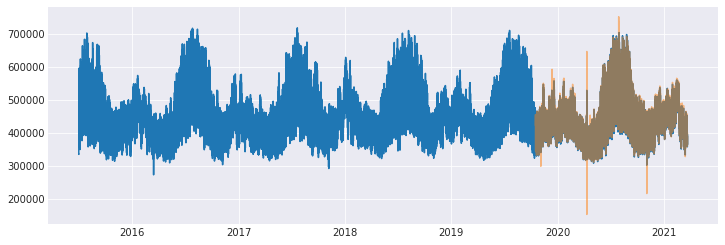

In [126]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, df['Megawatthours'])
ax.plot(df.index[-12540:], unscaled_preds, alpha=.5)
plt.show()

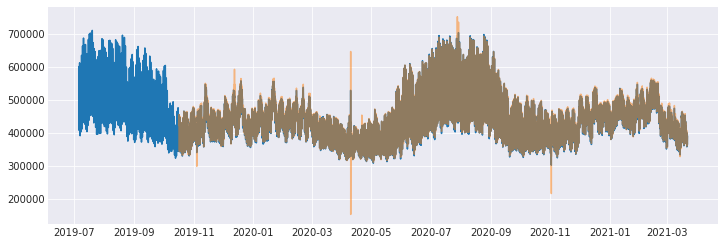

In [128]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index[-15000:], df['Megawatthours'].iloc[-15000:])
ax.plot(df.index[-12540:], unscaled_preds, alpha=.5)
plt.show()